In [1]:
import jetson.inference
import jetson.utils
import argparse
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class segmentationBuffers:
    def __init__(self, net):
        self.net = net
        self.mask = None
        self.overlay = None
        self.composite = None
        self.class_mask = None
        
        self.use_stats = True
        self.use_mask = False
        self.use_overlay = True
        self.use_composite = self.use_mask and self.use_overlay
        
        if not self.use_overlay and not self.use_mask:
            raise Exception("invalid visualize flags - valid values are 'overlay' 'mask' 'overlay,mask'")
             
        self.grid_width, self.grid_height = net.GetGridSize()	
        self.num_classes = net.GetNumClasses()

    @property
    def output(self):
        if self.use_overlay and self.use_mask:
            return self.composite
        elif self.use_overlay:
            return self.overlay
        elif self.use_mask:
            return self.mask
            
    def Alloc(self, shape, format):
        if self.overlay is not None and self.overlay.height == shape[0] and self.overlay.width == shape[1]:
            return

        if self.use_overlay:
            self.overlay = jetson.utils.cudaAllocMapped(width=shape[1], height=shape[0], format=format)

        if self.use_mask:
            mask_downsample = 2 if self.use_overlay else 1
            self.mask = jetson.utils.cudaAllocMapped(width=shape[1]/mask_downsample, height=shape[0]/mask_downsample, format=format) 

        if self.use_composite:
            self.composite = jetson.utils.cudaAllocMapped(width=self.overlay.width+self.mask.width, height=self.overlay.height, format=format) 

        if self.use_stats:
            self.class_mask = jetson.utils.cudaAllocMapped(width=self.grid_width, height=self.grid_height, format="gray8")
            self.class_mask_np = jetson.utils.cudaToNumpy(self.class_mask)
            
    def ComputeStats(self):
        if not self.use_stats:
            return
            
        # get the class mask (each pixel contains the classID for that grid cell)
        self.net.Mask(self.class_mask, self.grid_width, self.grid_height)

        # compute the number of times each class occurs in the mask
        class_histogram, _ = np.histogram(self.class_mask_np, self.num_classes)

        print('grid size:   {:d}x{:d}'.format(self.grid_width, self.grid_height))
        print('num classes: {:d}'.format(self.num_classes))

        print('-----------------------------------------')
        print(' ID  class name        count     %')
        print('-----------------------------------------')

        for n in range(self.num_classes):
            percentage = float(class_histogram[n]) / float(self.grid_width * self.grid_height)
            print(' {:>2d}  {:<18s} {:>3d}   {:f}'.format(n, self.net.GetClassDesc(n), class_histogram[n], percentage)) 

In [3]:
model = "fcn-resnet18-cityscapes"
overlay_Alpha = 150
filter_mode = "linear" # "linear", choices=["point", "linear"]
ignore_class = "void"
samples = ["samples/city_0.jpg", "samples/city_1.jpg"]

In [4]:
net = jetson.inference.segNet(model)
net.SetOverlayAlpha(overlay_Alpha)
buffers = segmentationBuffers(net)

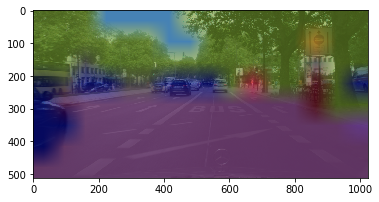

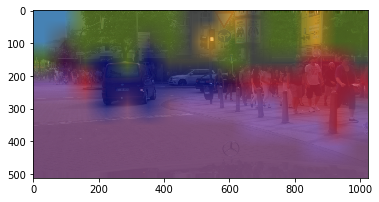

In [5]:
for sample in samples:
    img = jetson.utils.loadImage(sample) # load an image (into shared CPU/GPU memory)
    buffers.Alloc(img.shape, img.format)
    net.Process(img, ignore_class=ignore_class)
    if buffers.overlay:
        net.Overlay(buffers.overlay, filter_mode=filter_mode) 
    if buffers.mask:
        net.Mask(buffers.mask, filter_mode=filter_mode)
    if buffers.composite:
        jetson.utils.cudaOverlay(buffers.overlay, buffers.composite, 0, 0)
        jetson.utils.cudaOverlay(buffers.mask, buffers.composite, buffers.overlay.width, 0)

    img_rander = jetson.utils.cudaToNumpy(buffers.output)
    plt.figure()
    plt.imshow(img_rander)
    plt.show()